In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz
from datetime import datetime, timedelta
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

## Exploring the data

In [2]:
raw_df = pd.read_csv('../../data/releases/flat/releases.csv')

In [3]:
raw_df.shape

(39079, 27)

In [4]:
raw_df.head(2).T

,0,1
id,4582161,7962644
status,Accepted,Accepted
resource_url,https://api.discogs.com/releases/4582161,https://api.discogs.com/releases/7962644
title,Top Stars & Hits,The Cornerstone Player 013
artists_sort,Various,Various
num_for_sale,2,2
date_added,2013-05-20T05:20:24-07:00,2016-01-11T02:13:02-08:00
lowest_price,18.0,13.21
released,1978,2000
country,Netherlands,US


### We only include release with a single format in the dataset

In [5]:
raw_df['format_names'] = raw_df.format_names.apply(ast.literal_eval)

In [6]:
raw_df = raw_df.loc[raw_df.format_names.str.len()==1]
raw_df['format_names'] = raw_df.format_names.str[0]

In [7]:
raw_df[['id', 'format_names']].groupby('format_names').nunique().sort_values('id', ascending=False).head(10)

,id
format_names,
CD,21993
Vinyl,7674
File,3807
CDr,1636
Cassette,1165
DVD,398
Shellac,144
VHS,97
Betacam SP,50


### Below, we focus on releases in the vinyl and CD format

In [8]:
raw_df = raw_df.loc[raw_df.format_names.isin(['CD', 'Vinyl'])]

In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29667 entries, 2 to 39078
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29667 non-null  int64  
 1   status                  29667 non-null  object 
 2   resource_url            29667 non-null  object 
 3   title                   29667 non-null  object 
 4   artists_sort            29667 non-null  object 
 5   num_for_sale            29667 non-null  int64  
 6   date_added              29667 non-null  object 
 7   lowest_price            24019 non-null  float64
 8   released                26992 non-null  object 
 9   country                 28963 non-null  object 
 10  genres                  29667 non-null  object 
 11  styles                  23793 non-null  object 
 12  estimated_weight        29666 non-null  float64
 13  blocked_from_sale       29667 non-null  bool   
 14  artist_ids              29667 non-null

# Extracting release features

### Genre and style

In [10]:
raw_df['genres'] = raw_df.genres.fillna("[None]").apply(ast.literal_eval)
raw_df['styles'] = raw_df.styles.fillna("[None]").apply(ast.literal_eval)

In [11]:
raw_df.genres.sample(3)

38335          [Jazz]
4683     [Electronic]
26225          [Rock]
Name: genres, dtype: object

### Item quantity

In [12]:
raw_df['vinyl_qty'] = raw_df.vinyl_qty.apply(ast.literal_eval).str[0]
raw_df['cd_qty'] = raw_df.cd_qty.apply(ast.literal_eval).str[0]

In [13]:
raw_df.vinyl_qty.unique()

array([ nan,   1.,   5.,   2.,   3.,   4.,  10.,  20.,   6.,   8.,   7.,
       104.])

In [14]:
raw_df.cd_qty.unique()

array([  1.,  nan,   2.,   3.,   4.,   6.,  24.,  10.,   5.,   8.,  12.,
        20.,   9.,  19.,  15.,  18.,  30., 500.,  23.,   7.,   0.])

### Release year

In [15]:
raw_df['release_year'] = raw_df.released.str[:4]

In [16]:
raw_df.release_year.unique()

array(['2007', '2003', '2016', '2004', '2018', '1992', '1997', '2001',
       '2006', nan, '1985', '1976', '1999', '1983', '2008', '2002',
       '2019', '2005', '1998', '2009', '2011', '1951', '1991', '2020',
       '2000', '1990', '2015', '2014', '1994', '1980', '1996', '1975',
       '2010', '1995', '2013', '1973', '2012', '2017', '1993', '1978',
       '1972', '1970', '1984', '1953', '1961', '1979', '1981', '1988',
       '1987', '1974', '1956', '1977', '1957', '1989', '1971', '1967',
       '1958', '1986', '1968', '1969', '1965', '2021', '1982', '1962',
       '1966', '1959', '1963', '1960', '1954', '1964', '1955', '1952',
       '1950', '1946', '1949'], dtype=object)

In [18]:
raw_df['days_since_added'] = (datetime.now(tz=pytz.utc) - pd.to_datetime(raw_df.date_added, utc=True)).dt.days
raw_df['year_added'] = pd.to_datetime(raw_df.date_added, utc=True).dt.year
raw_df['years_since_release'] = 2021- raw_df.release_year.fillna(raw_df.year_added).astype(int)


In [19]:
raw_df.head(3).T

,2,3,4
id,2418890,262771,19527100
status,Accepted,Accepted,Accepted
resource_url,https://api.discogs.com/releases/2418890,https://api.discogs.com/releases/262771,https://api.discogs.com/releases/19527100
title,A History Of Schema: Numero Due,Pink Mini Compilation,Forever Gold
artists_sort,Various,Various,Various
num_for_sale,0,18,1
date_added,2010-08-28T12:10:51-07:00,2004-06-07T16:55:30-07:00,2021-07-17T08:09:25-07:00
lowest_price,NaN,1.77,7.06
released,2007,2003-12-00,2007
country,Japan,Germany,Canada


## Inspecting `status` and `blocked_from_sale` columns

In [20]:
raw_df[['status', 'id']].groupby('status').count()

,id
status,
Accepted,29667


In [21]:
raw_df[['blocked_from_sale', 'id']].groupby('blocked_from_sale').count().sort_values('id', ascending=False).head(10)

,id
blocked_from_sale,
False,28800
True,867


# Plotting uni- and bi-variate distributions

In [22]:
raw_df.columns

Index(['id', 'status', 'resource_url', 'title', 'artists_sort', 'num_for_sale',
       'date_added', 'lowest_price', 'released', 'country', 'genres', 'styles',
       'estimated_weight', 'blocked_from_sale', 'artist_ids', 'label_ids',
       'distributor_ids', 'mastered_ids', 'format_names', 'vinyl_qty',
       'cd_qty', 'community_haves', 'community_wants',
       'community_rating_count', 'community_rating_avg', 'n_videos',
       'n_tracks', 'release_year', 'days_since_added', 'year_added',
       'years_since_release'],
      dtype='object')

### Number of items for sale per release

In [23]:
raw_df.num_for_sale.describe()

count    29667.000000
mean         5.998685
std          8.019336
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        195.000000
Name: num_for_sale, dtype: float64

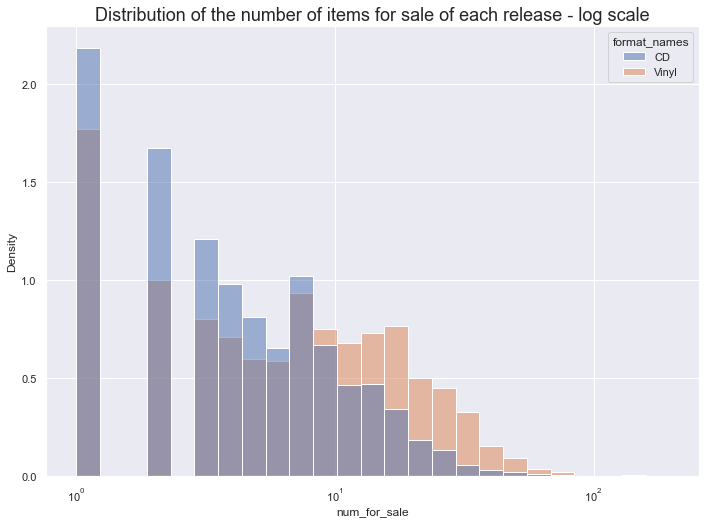

In [24]:
ax= sns.histplot(data= raw_df, x=  1 +raw_df.num_for_sale, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of the number of items for sale of each release - log scale', fontsize=18);

### Lowest price per release

In [25]:
raw_df.lowest_price.describe()

count    24019.000000
mean         9.286509
std         26.413123
min          0.010000
25%          2.430000
50%          4.900000
75%          9.490000
max       2364.440000
Name: lowest_price, dtype: float64

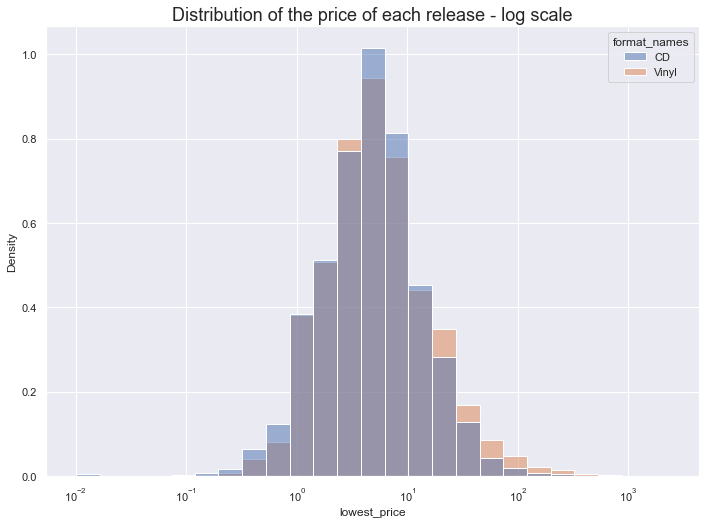

In [26]:
ax= sns.histplot(data= raw_df, x=raw_df.lowest_price, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of the price of each release - log scale', fontsize=18);

### Average community rating per release

In [27]:
raw_df.community_rating_avg.describe()

count    29667.000000
mean         2.784338
std          2.080121
min          0.000000
25%          0.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: community_rating_avg, dtype: float64

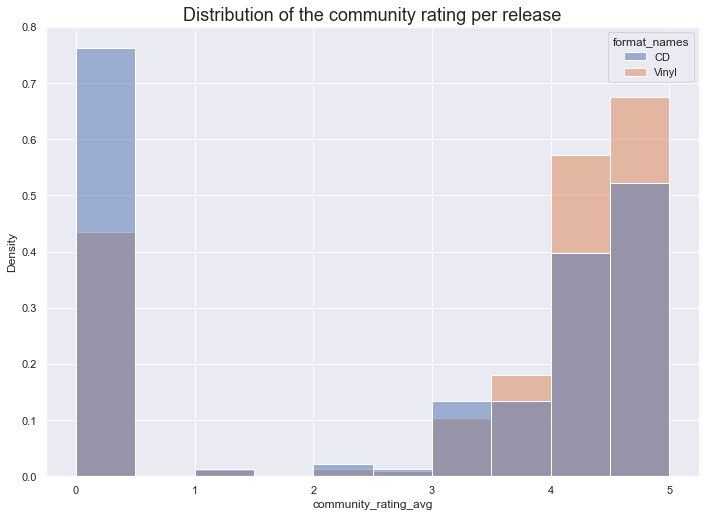

In [28]:
ax= sns.histplot(data= raw_df, x=raw_df.community_rating_avg, hue='format_names', bins=10,
                 stat='density', common_norm=False, log_scale=False);
plt.title('Distribution of the community rating per release', fontsize=18);

In [29]:
raw_df.community_rating_count.describe()

count    29667.000000
mean         5.585297
std         13.915336
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max        505.000000
Name: community_rating_count, dtype: float64

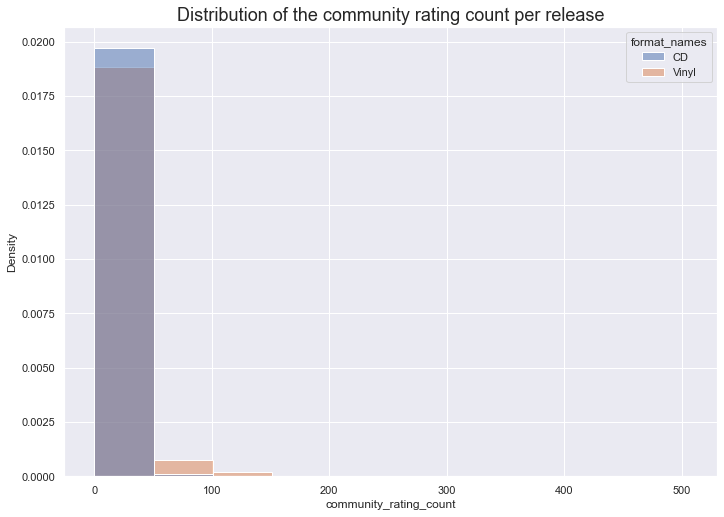

In [30]:
ax= sns.histplot(data= raw_df, x= raw_df.community_rating_count, hue='format_names', bins=10,
                 stat='density', common_norm=False, log_scale=False);
plt.title('Distribution of the community rating count per release', fontsize=18);

### Community "haves" and "wants"

In [31]:
raw_df.community_haves.describe()

count    29667.000000
mean        39.950147
std         91.115095
min          0.000000
25%          3.000000
50%         12.000000
75%         38.000000
max       3357.000000
Name: community_haves, dtype: float64

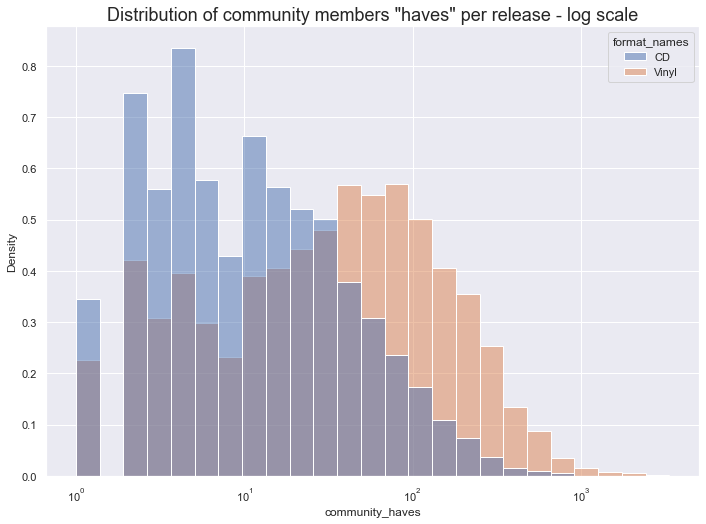

In [32]:
ax= sns.histplot(data= raw_df, x= 1 + raw_df.community_haves, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of community members "haves" per release - log scale', fontsize=18);

In [33]:
raw_df.community_wants.describe()

count    29667.000000
mean        21.917686
std         71.017734
min          0.000000
25%          1.000000
50%          4.000000
75%         16.000000
max       3409.000000
Name: community_wants, dtype: float64

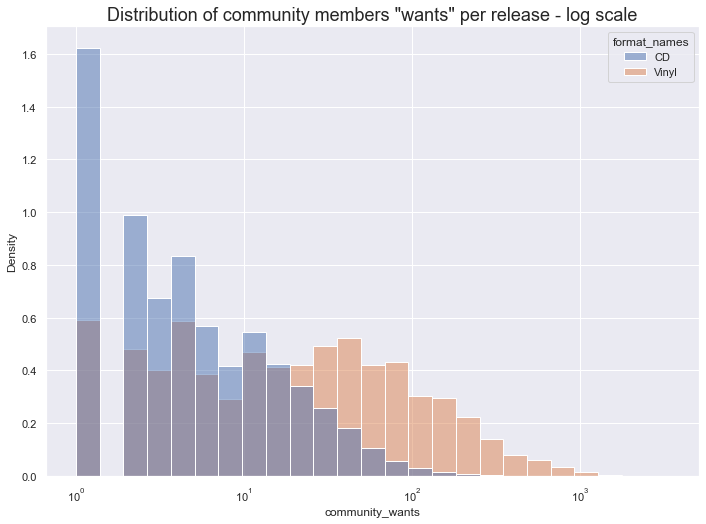

In [34]:
ax= sns.histplot(data= raw_df, x= 1 + raw_df.community_wants, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of community members "wants" per release - log scale', fontsize=18);

### Number of tracks per release

In [35]:
raw_df.n_tracks.describe()

count    29667.000000
mean        22.757812
std         23.380464
min          1.000000
25%         11.000000
50%         16.000000
75%         28.000000
max        510.000000
Name: n_tracks, dtype: float64

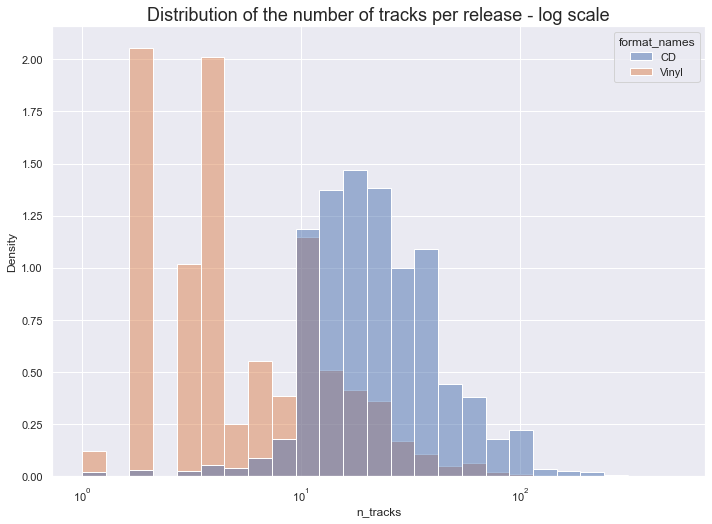

In [36]:
ax= sns.histplot(data= raw_df, x=raw_df.n_tracks, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of the number of tracks per release - log scale', fontsize=18);

## Years since release

In [37]:
raw_df.years_since_release.describe()

count    29667.000000
mean        18.597330
std         11.262354
min          0.000000
25%         12.000000
50%         18.000000
75%         23.000000
max         75.000000
Name: years_since_release, dtype: float64

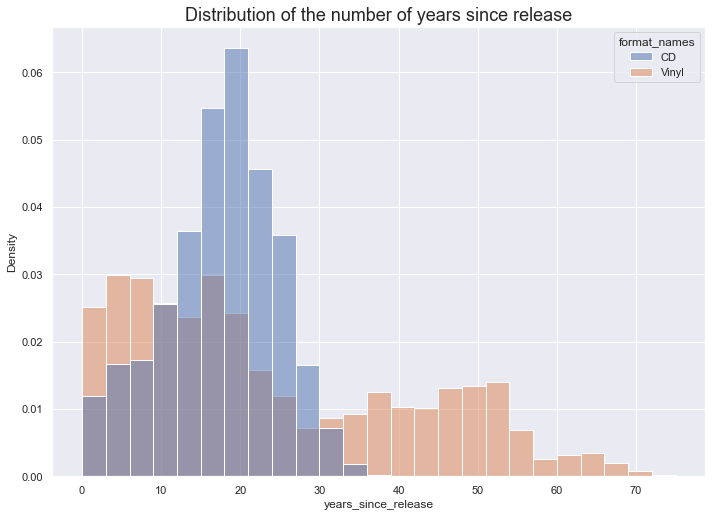

In [38]:
ax= sns.histplot(data= raw_df, x= raw_df.years_since_release, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=False);
plt.title('Distribution of the number of years since release', fontsize=18);

## Bi-variate distributions

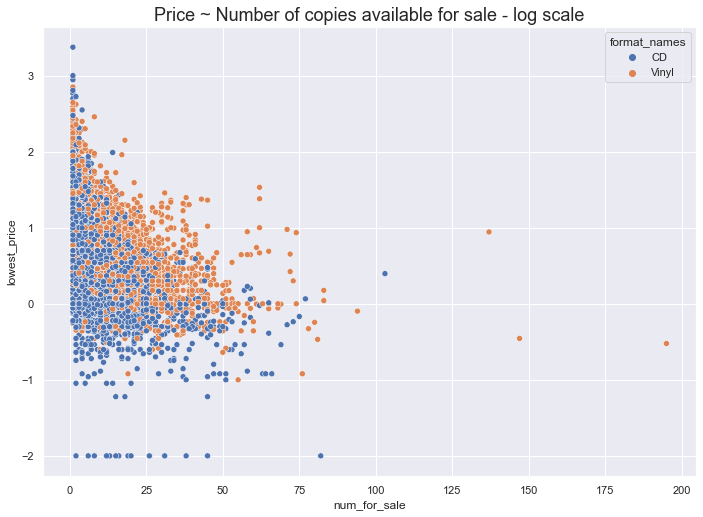

In [39]:
ax = sns.scatterplot(x='num_for_sale', y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Number of copies available for sale - log scale', fontsize=18);

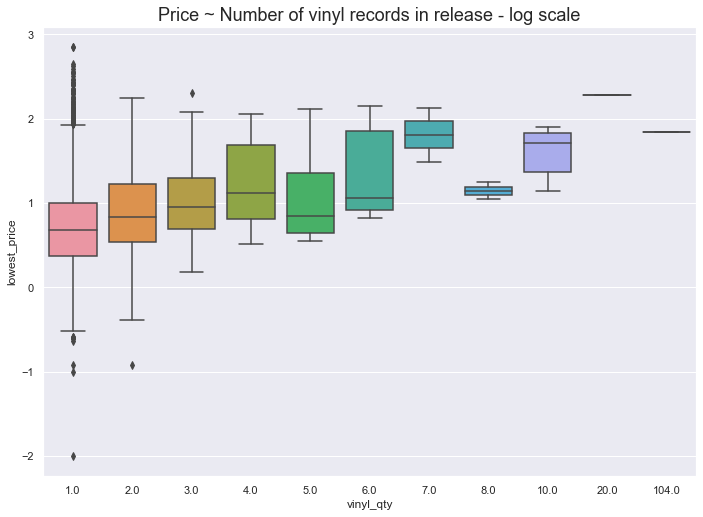

In [40]:
ax = sns.boxplot(x='vinyl_qty', y=np.log10(raw_df.lowest_price), data=raw_df)
plt.title('Price ~ Number of vinyl records in release - log scale', fontsize=18);

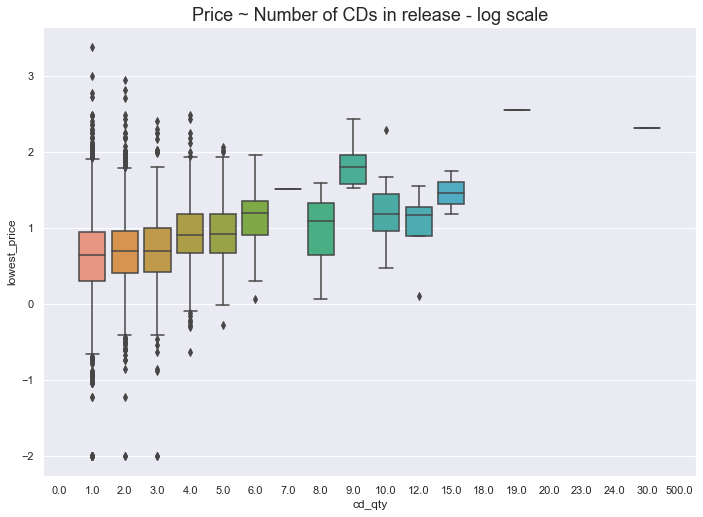

In [41]:
ax = sns.boxplot(x='cd_qty', y=np.log10(raw_df.lowest_price), data=raw_df)
plt.title('Price ~ Number of CDs in release - log scale', fontsize=18);

In [42]:
raw_df[['id', 'country']].groupby('country').nunique().sort_values('id', ascending=False).head(10)

,id
country,
UK,5433
US,4551
Germany,3196
France,1725
Netherlands,1516
Europe,1498
Japan,1290
Italy,1190
Belgium,836


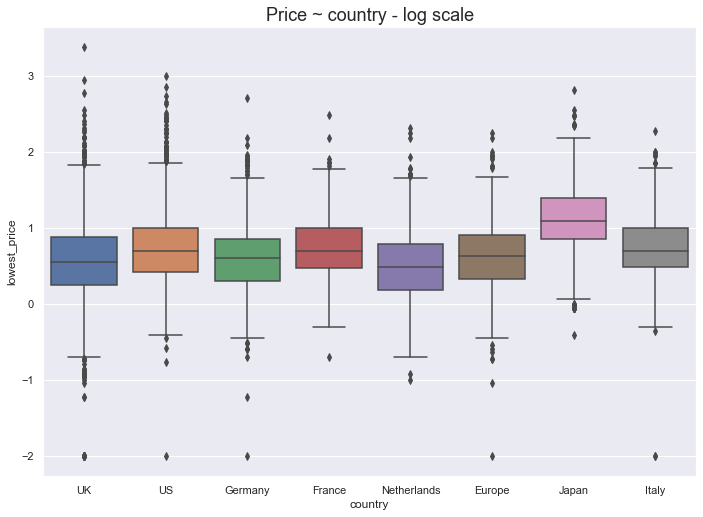

In [43]:
ax = sns.boxplot(x='country', y=np.log10(raw_df.loc[raw_df.country.isin(['UK', 'US', 'Germany', 'France', 'Netherlands', 'Europe', 'Japan', 'Italy'])].lowest_price),
                 data=raw_df.loc[raw_df.country.isin(['UK', 'US', 'Germany', 'France', 'Netherlands', 'Europe', 'Japan', 'Italy'])],
                 order=['UK', 'US', 'Germany', 'France', 'Netherlands', 'Europe', 'Japan', 'Italy']
                )
plt.title('Price ~ country - log scale', fontsize=18);

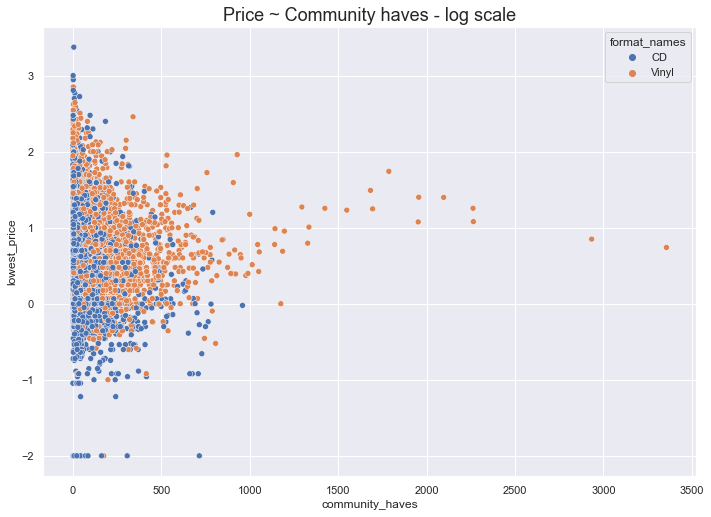

In [44]:
ax = sns.scatterplot(x='community_haves', y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Community haves - log scale', fontsize=18);

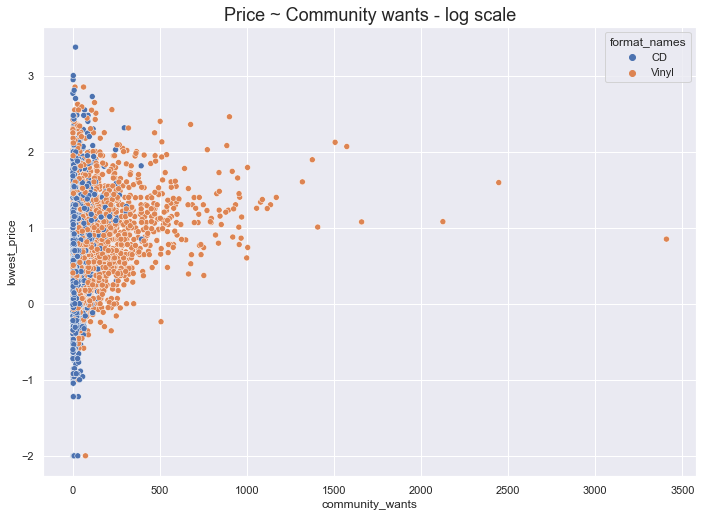

In [45]:
ax = sns.scatterplot(x='community_wants', y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Community wants - log scale', fontsize=18);

## Creating 2 desirability metrics
- we define `desirability` as `wants - haves`
- we define `desirability_ratio` as `(wants - haves)/(1 + haves)`

In [46]:
raw_df['desirability'] = raw_df.community_wants - raw_df.community_haves
raw_df['desirability_ratio'] = (raw_df.community_wants - raw_df.community_haves)/(1+ raw_df.community_haves)

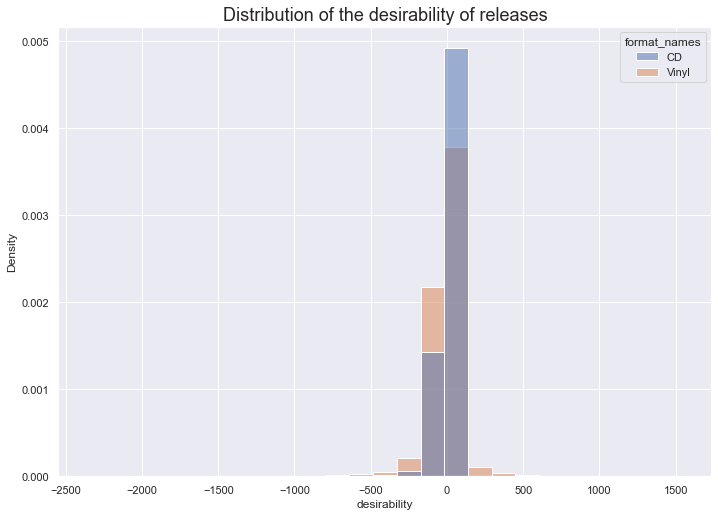

In [47]:
ax= sns.histplot(data= raw_df, x=raw_df.desirability, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=False);
plt.title('Distribution of the desirability of releases', fontsize=18);

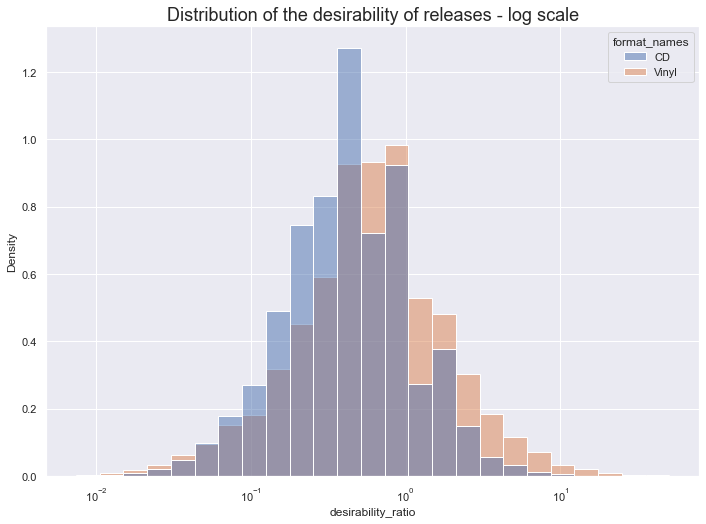

In [48]:
ax= sns.histplot(data= raw_df, x=1+raw_df.desirability_ratio, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of the desirability of releases - log scale', fontsize=18);

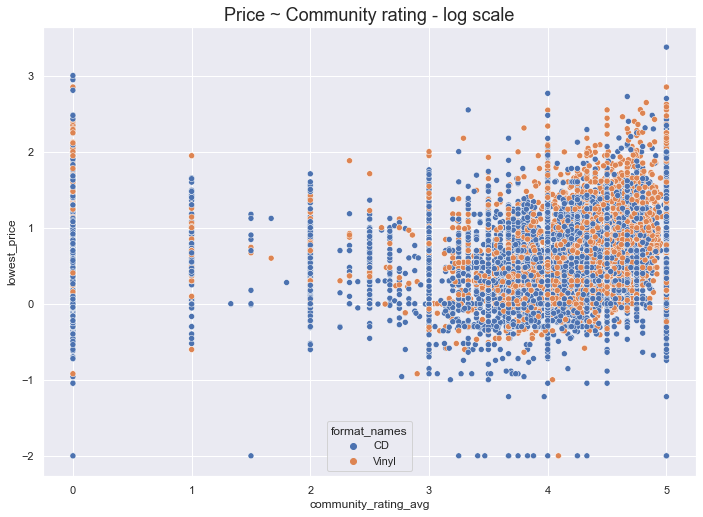

In [49]:
ax = sns.scatterplot(x=raw_df.community_rating_avg, y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Community rating - log scale', fontsize=18);

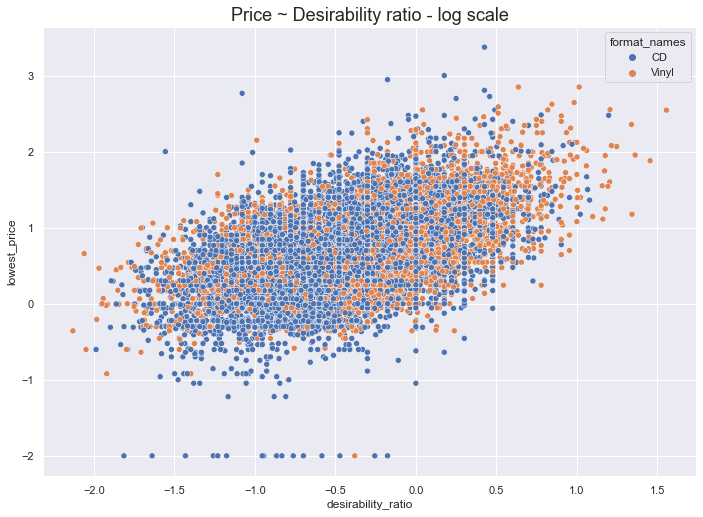

In [50]:
ax = sns.scatterplot(x=np.log10(1 + raw_df.desirability_ratio), y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Desirability ratio - log scale', fontsize=18);

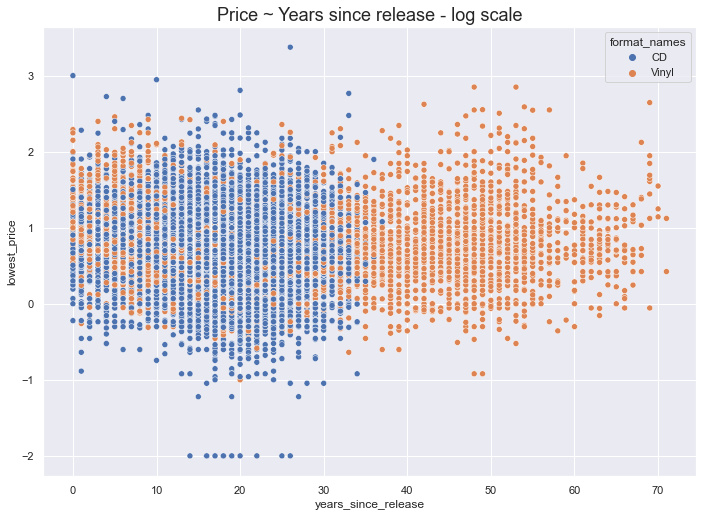

In [51]:
ax = sns.scatterplot(x=raw_df.years_since_release, y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Years since release - log scale', fontsize=18);

In [52]:
single_genre_df = raw_df.loc[raw_df.genres.str.len()==1].copy()
single_genre_df['genre'] = single_genre_df.genres.str[0]

In [53]:
ordered_genres = single_genre_df[['genre', 'lowest_price']].groupby('genre', as_index=False).median().sort_values('lowest_price').genre.tolist()

In [54]:
single_genre_df.head(1)

,id,status,resource_url,title,artists_sort,num_for_sale,date_added,lowest_price,released,country,...,community_rating_avg,n_videos,n_tracks,release_year,days_since_added,year_added,years_since_release,desirability,desirability_ratio,genre
2,2418890,Accepted,https://api.discogs.com/releases/2418890,A History Of Schema: Numero Due,Various,0,2010-08-28T12:10:51-07:00,NaN,2007,Japan,...,5.0,NaN,19,2007,4150,2010,14,1,0.2,Electronic


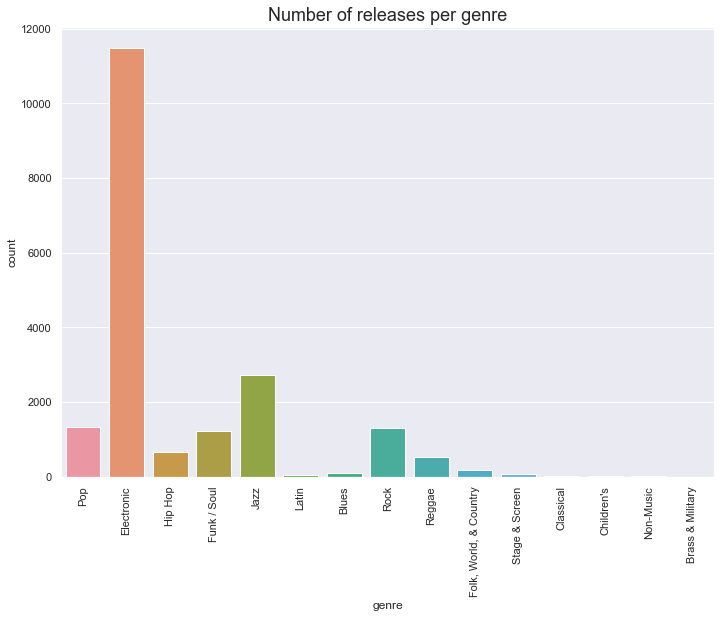

In [55]:
ax = sns.countplot(x=single_genre_df.genre,
                 data=single_genre_df, order=ordered_genres)
plt.title('Number of releases per genre', fontsize=18);
plt.xticks(rotation=90);

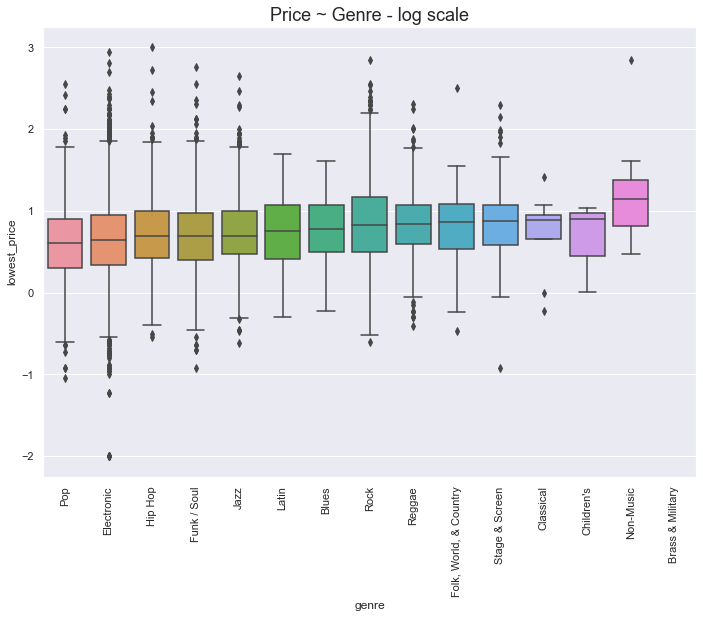

In [56]:
ax = sns.boxplot(x=single_genre_df.genre, y=np.log10(single_genre_df.lowest_price), 
                 data=single_genre_df, order=ordered_genres)
plt.title('Price ~ Genre - log scale', fontsize=18);
plt.xticks(rotation=90);

In [57]:
single_style_df = single_genre_df.loc[single_genre_df.styles.str.len()==1].copy()
single_style_df['style_name'] = single_style_df.styles.str[0]

In [60]:
ordered_electronic_styles = single_style_df.loc[single_style_df.genre == 'Electronic'][['style_name', 'lowest_price']].groupby('style_name', as_index=False).median().sort_values('lowest_price').style_name.tolist()

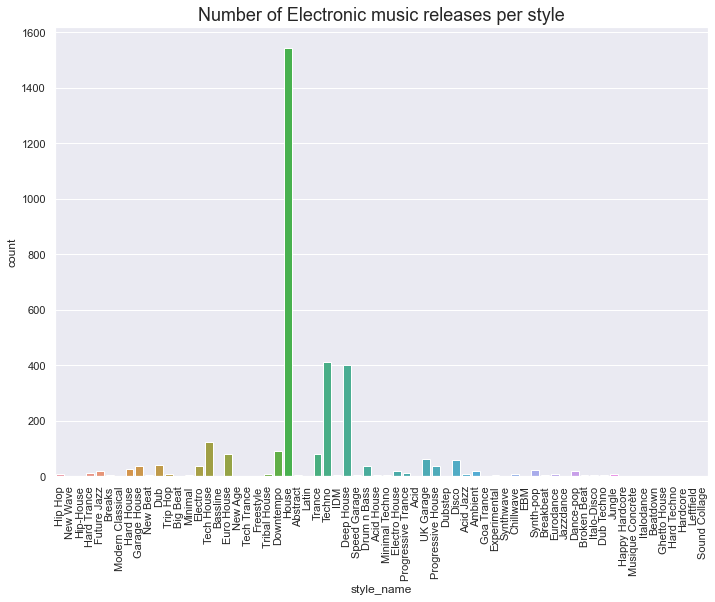

In [61]:
ax = sns.countplot(x=single_style_df.style_name,
                 data=single_style_df, order=ordered_electronic_styles)
plt.title('Number of Electronic music releases per style', fontsize=18);
plt.xticks(rotation=90);

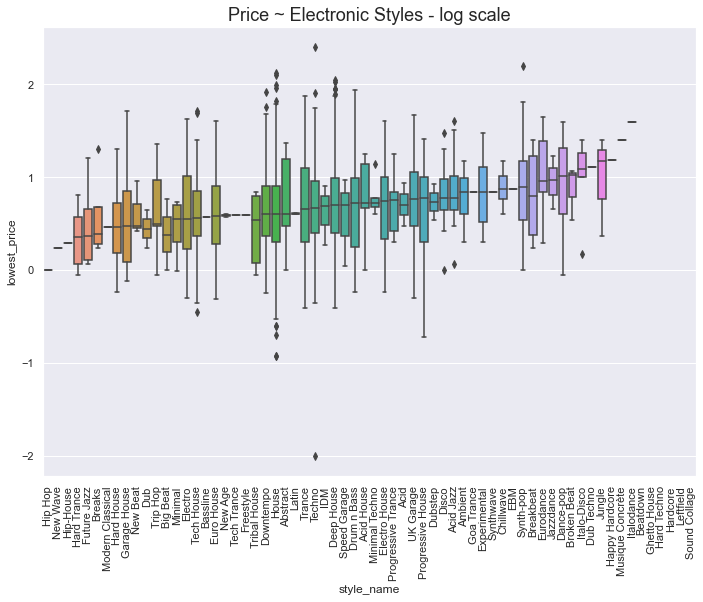

In [62]:
ax = sns.boxplot(
    x=single_style_df.loc[single_style_df.genre == 'Electronic'].style_name, 
    y=np.log10(single_style_df.loc[single_style_df.genre == 'Electronic'].lowest_price),
    order=ordered_electronic_styles
                )
plt.title('Price ~ Electronic Styles - log scale', fontsize=18);
plt.xticks(rotation=90);

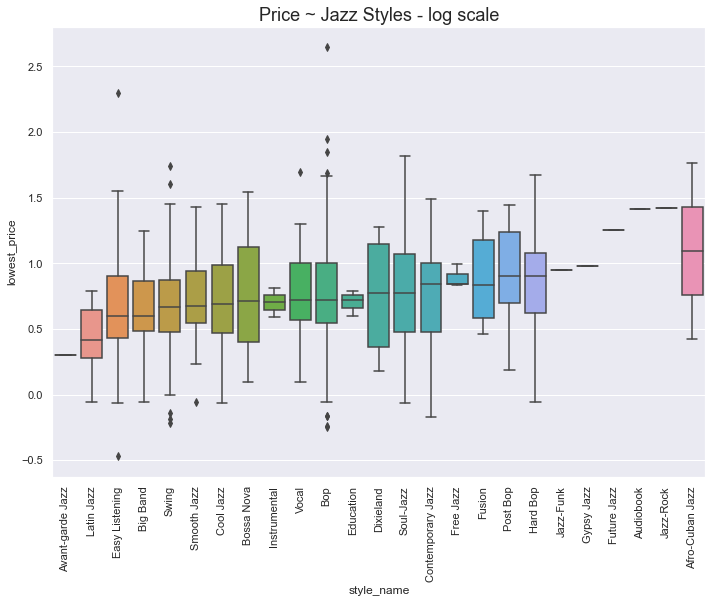

In [63]:
ordered_jazz_styles = single_style_df.loc[single_style_df.genre == 'Jazz'][['style_name', 'lowest_price']].groupby('style_name', as_index=False).median().sort_values('lowest_price').style_name.tolist()
ax = sns.boxplot(x=single_style_df.loc[single_style_df.genre == 'Jazz'].style_name, 
                 y=np.log10(single_style_df.loc[single_style_df.genre == 'Jazz'].lowest_price),
                order=ordered_jazz_styles)
plt.title('Price ~ Jazz Styles - log scale', fontsize=18);
plt.xticks(rotation=90);

### Comments
It looks like some correlations emerge:
- The number of copies of a release for sale look correlated to the minimum price the release is sold for: the less copies for sale, the more expensive
- The number of vinyl records/CDs in a release also look correlated to the price: the more records/CDs, the higher the price
- The desirability ratio of a release also looks to be correlated with its price


In addition, it looks like the price is dependent on the genre/style of the release, and that its variance changes across styles. 

In [64]:
raw_df.head(1).T

,2
id,2418890
status,Accepted
resource_url,https://api.discogs.com/releases/2418890
title,A History Of Schema: Numero Due
artists_sort,Various
num_for_sale,0
date_added,2010-08-28T12:10:51-07:00
lowest_price,NaN
released,2007
country,Japan


In [65]:
raw_df.shape

(29667, 33)

## Predicting Price ~ num_for_sale + genre + format + item_qty + n_tracks + desirability_ratio

In [66]:
raw_df['item_qty'] = raw_df.vinyl_qty.fillna(raw_df.cd_qty)

In [67]:
clean_df = raw_df[[
    'num_for_sale', 'lowest_price', 'format_names', 'item_qty', 'genres', 'years_since_release', 'desirability_ratio'
            ]].reset_index(drop=True)

In [68]:
clean_df.dropna(inplace=True)
clean_df.reset_index(drop=True, inplace=True)

In [69]:
clean_df.isnull().sum()

num_for_sale           0
lowest_price           0
format_names           0
item_qty               0
genres                 0
years_since_release    0
desirability_ratio     0
dtype: int64

In [70]:
clean_df.shape

(24019, 7)

In [71]:
single_genre_df = clean_df.loc[clean_df.genres.str.len()==1].copy()
single_genre_df['intercept']=1
single_genre_df['genre'] = single_genre_df.genres.str[0]

In [72]:
linear_model = sm.OLS(endog=single_genre_df["lowest_price"], 
                      exog=single_genre_df[['intercept', 'num_for_sale', 'item_qty', 'desirability_ratio']], 
                      data=single_genre_df, hasconst=True)
linear_results = linear_model.fit()
print(linear_results.summary())

                            OLS Regression Results                            
Dep. Variable:           lowest_price   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     809.8
Date:                Sat, 08 Jan 2022   Prob (F-statistic):               0.00
Time:                        01:05:18   Log-Likelihood:                -72934.
No. Observations:               16309   AIC:                         1.459e+05
Df Residuals:                   16305   BIC:                         1.459e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             11.1272      0

/Users/yemiogoundele/Desktop/Projects/DS/vinyl-marketplace/vinyl-record-prices/env/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


In [73]:
linear_results.params

intercept             11.127187
num_for_sale          -0.283101
item_qty               1.690592
desirability_ratio     7.491158
dtype: float64

## Include format in mixed effect model

In [74]:
format_md = smf.mixedlm("lowest_price ~ num_for_sale+ item_qty + desirability_ratio", data=
                 single_genre_df, 
                 re_formula="~item_qty + desirability_ratio + num_for_sale",
                 groups=single_genre_df["format_names"])
format_mdf = format_md.fit(method=["lbfgs"])
print(format_mdf.summary())

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        lowest_price
No. Observations:         16309          Method:                    REML        
No. Groups:               2              Scale:                     447.1009    
Min. group size:          4926           Log-Likelihood:            -72918.1264 
Max. group size:          11383          Converged:                 Yes         
Mean group size:          8154.5                                                
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             11.073    1.938  5.714 0.000  7.275 14.871
num_for_sale                          -0.329    0.897 -0.366 0.714 -2.087  1.430
item_qty                               1.859    0.

/Users/yemiogoundele/Desktop/Projects/DS/vinyl-marketplace/vinyl-record-prices/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


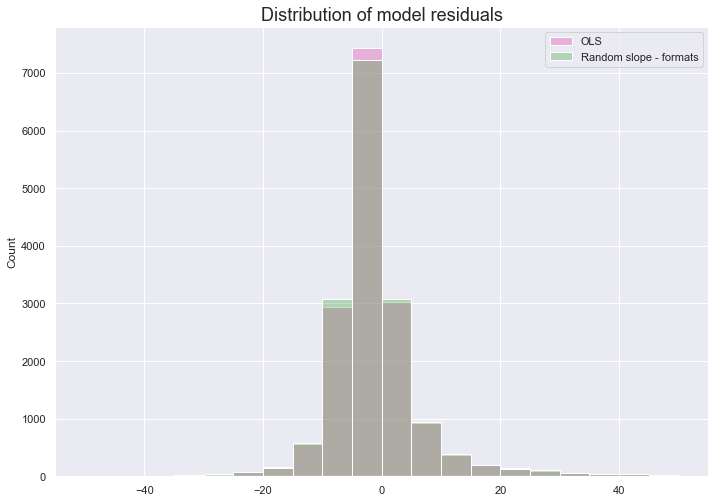

In [80]:
ax= sns.histplot(data= linear_results.resid, bins=np.arange(-50, 55, 5), color='tab:pink', alpha=0.5)
ax= sns.histplot(data= format_mdf.resid, bins=np.arange(-50, 55, 5), color='tab:green', alpha=0.3)

plt.title('Distribution of model residuals', fontsize=18);
ax.legend(['OLS', 'Random slope - formats'])

## Include Genres in mixed effect model

In [81]:
md = smf.mixedlm("lowest_price ~ num_for_sale+ item_qty + desirability_ratio", data=
                 single_genre_df, 
                 re_formula="~item_qty + desirability_ratio + num_for_sale",
                 groups=single_genre_df["genre"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        lowest_price
No. Observations:         16309          Method:                    REML        
No. Groups:               14             Scale:                     425.2063    
Min. group size:          3              Log-Likelihood:            -72549.7757 
Max. group size:          10046          Converged:                 Yes         
Mean group size:          1164.9                                                
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             13.207    2.398  5.507 0.000  8.506 17.907
num_for_sale                          -0.258    0.225 -1.149 0.250 -0.698  0.182
item_qty                               3.092    0.

/Users/yemiogoundele/Desktop/Projects/DS/vinyl-marketplace/vinyl-record-prices/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


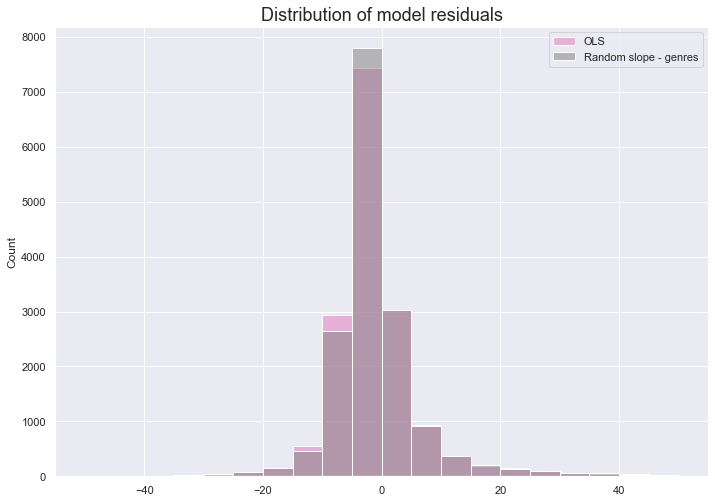

In [82]:
ax= sns.histplot(data= linear_results.resid, bins=np.arange(-50, 55, 5), color='tab:pink', alpha=0.5)
ax= sns.histplot(data= mdf.resid, bins=np.arange(-50, 55, 5), color='tab:grey', alpha=0.5)

plt.title('Distribution of model residuals', fontsize=18);
ax.legend(['OLS', 'Random slope - genres'])

In [83]:
mdf.random_effects['Electronic']

Group                -3.608484
item_qty             -1.667273
desirability_ratio   -5.080374
num_for_sale         -0.002919
dtype: float64

In [84]:
mdf.random_effects['Jazz']

Group                 0.556668
item_qty             -1.967320
desirability_ratio   -1.458180
num_for_sale          0.015935
dtype: float64

In [85]:
mdf.random_effects['Pop']

Group                -1.385649
item_qty             -2.214103
desirability_ratio   -4.105908
num_for_sale         -0.093551
dtype: float64

In [86]:
def abline(slope, intercept, color):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color)

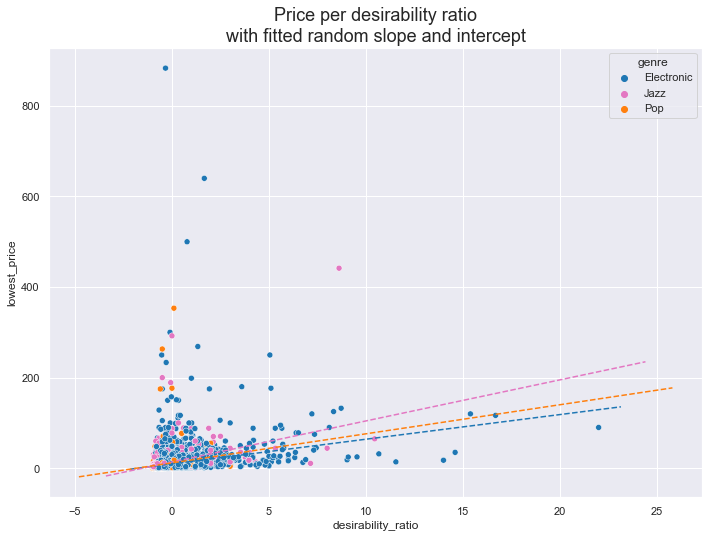

In [89]:
sns.scatterplot(data=single_genre_df.loc[single_genre_df.genre.isin(['Electronic', 'Jazz', 'Pop'])], 
                hue='genre', x='desirability_ratio', y='lowest_price', palette=['tab:blue', 'tab:pink', 'tab:orange'])
abline(intercept=mdf.random_effects['Electronic']['Group'] + mdf.params['Intercept'], 
       slope=mdf.random_effects['Electronic']['desirability_ratio'] + mdf.params['desirability_ratio'],
      color='tab:blue')
abline(intercept=mdf.random_effects['Jazz']['Group'] + mdf.params['Intercept'], 
       slope=mdf.random_effects['Jazz']['desirability_ratio'] + mdf.params['desirability_ratio'],
      color='tab:pink')
abline(intercept=mdf.random_effects['Pop']['Group'] + mdf.params['Intercept'], 
       slope=mdf.random_effects['Pop']['desirability_ratio'] + mdf.params['desirability_ratio'],
      color='tab:orange')
plt.title('Price per desirability ratio\nwith fitted random slope and intercept', fontsize=18);

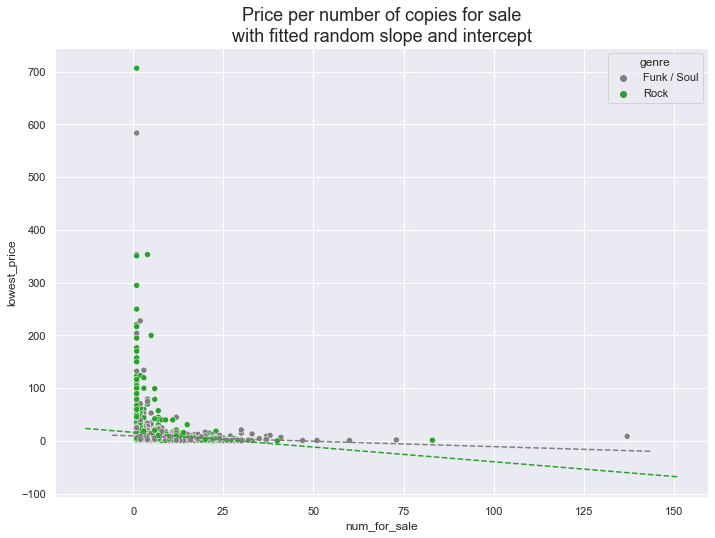

In [90]:
sns.scatterplot(data=single_genre_df.loc[single_genre_df.genre.isin(['Funk / Soul', 'Rock'])], 
                hue='genre', x='num_for_sale', y='lowest_price', palette=['tab:grey', 'tab:green'])
abline(intercept=mdf.random_effects['Funk / Soul']['Group'] + mdf.params['Intercept'], 
       slope=mdf.random_effects['Funk / Soul']['num_for_sale'] + mdf.params['num_for_sale'],
      color='tab:grey')
abline(intercept=mdf.random_effects['Rock']['Group'] + mdf.params['Intercept'], 
       slope=mdf.random_effects['Rock']['num_for_sale'] + mdf.params['num_for_sale'],
      color='tab:green')
plt.title('Price per number of copies for sale\nwith fitted random slope and intercept', fontsize=18);